## Non-variational fixed-depth Hamiltonian simulation

Here we time the FDHS example with non-variational KAK decomposition.

In [1]:
from itertools import combinations, product
import numpy as np
import time
np.random.seed(2415)
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I

from kak_tools import (
    map_simple_to_irrep,
    map_irrep_to_matrices,
    lie_closure_pauli_words,
    recursive_bdi,
    map_recursive_decomp_to_reducible,
    irrep_dot,
    make_signs,
    make_so_2n,
    make_so_2n_horizontal_mapping,
    make_so_2n_full_mapping,
)

In [2]:
# Helper functions
def make_so_2n_hamiltonian(n, coefficients="random"):
    couplings = [X(w) @ X(w+1) for w in range(n-1)] + [Y(w) @ Y(w+1) for w in range(n-1)]
    Zs = [Z(w) for w in range(n)]
    generators = couplings + Zs
    if coefficients == "random":
        alphas = np.random.normal(0.6, 1., size=n-1)
        betas = np.random.normal(0.3, 1.2, size=n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "random TF":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "uniform":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.ones(n)
    
    coeffs = np.concatenate([alphas, betas, gammas])
    coeffs /= np.linalg.norm(coeffs) # Normalization
    H = qml.dot(coeffs, generators)
    generators = [next(iter(op.pauli_rep)) for op in generators]
    return H, generators, coeffs

In [3]:
# Config

coefficients = "random"
use_predefined_algebra = True
use_predefined_horizontal_mapping = True
use_hardcoded_mapping = True
ns = np.arange(2, 15, dtype=int) ** 2
# ns = [10]
print(ns)

[  4   9  16  25  36  49  64  81 100 121 144 169 196]


In [4]:
times_mapping = []
times_decomposing = []
times_mapping_back = []
times_rest = []
times_total = []

for n in ns:
    n = int(n)
    H, generators, coeffs = make_so_2n_hamiltonian(n, coefficients)
    n_so = 2 * n
    so_dim = (n_so**2-n_so) // 2
    
    start = time.process_time()

    if use_predefined_algebra:
        algebra = make_so_2n(n)
    else:
        algebra = lie_closure_pauli_words(generators, verbose=False)
    start = time.process_time()
    assert len(algebra) == so_dim, f"{len(algebra)}, {so_dim}"

    start_mapping = time.process_time()

    if not use_hardcoded_mapping:
        if use_predefined_horizontal_mapping:
            horizontal_ops = make_so_2n_horizontal_mapping(n)
        else:
            horizontal_ops = generators
        # print(f"Mapping simple to irrep")
        mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=horizontal_ops, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})
        # print(f"Mapping irrep to matrices")
    else:
        mapping = make_so_2n_full_mapping(n)
        signs = make_signs(mapping, n_so, "BDI")

    end_mapping = time.process_time()

    epsilon = 0.01
    # print(f"Computing H and time evolution")
    H_irrep = irrep_dot(coeffs, generators, mapping, signs, n=n_so, invol_type="BDI")
    U = expm(epsilon * H_irrep)

    # print(f"Computing recursive decomposition")
    start_decomposing = time.process_time()
    recursive_decomp = recursive_bdi(U, n_so, validate=False)
    end_decomposing = time.process_time()

    # print(f"Mapping recursive decomposition to Paulis")
    start_mapping_back = time.process_time()
    pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, invol_type="BDI", time=epsilon, tol=None, validate=False)
    end_mapping_back = time.process_time()
    paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw), pw.wires, _type) for pw, coeff, _type in pauli_decomp]

    end = time.process_time()
    
    times_mapping.append(end_mapping - start_mapping)
    times_decomposing.append(end_decomposing - start_decomposing)
    times_mapping_back.append(end_mapping_back - start_mapping_back)
    times_total.append(end - start)
    times_rest.append(times_total[-1] - times_mapping[-1] - times_mapping_back[-1] - times_decomposing[-1])
    
    print(f"Decomposed exp(iHt) on {n} qubits into {len(paulirot_decomp)} Pauli rotations (DLA dimension: {so_dim}, Duration: {times_total[-1]:.3}s).")

Decomposed exp(iHt) on 4 qubits into 28 Pauli rotations (DLA dimension: 28, Duration: 0.0052s).
Decomposed exp(iHt) on 9 qubits into 153 Pauli rotations (DLA dimension: 153, Duration: 0.0225s).
Decomposed exp(iHt) on 16 qubits into 496 Pauli rotations (DLA dimension: 496, Duration: 0.0442s).
Decomposed exp(iHt) on 25 qubits into 1225 Pauli rotations (DLA dimension: 1225, Duration: 0.114s).


/home/david/repos/kak-tools/kak_tools/dense_cartan.py:151: RuntimeWarning: invalid value encountered in arcsin
  angle = np.arcsin(matrix[i, j])


Decomposed exp(iHt) on 36 qubits into 2552 Pauli rotations (DLA dimension: 2556, Duration: 0.225s).
Decomposed exp(iHt) on 49 qubits into 4729 Pauli rotations (DLA dimension: 4753, Duration: 0.458s).
Decomposed exp(iHt) on 64 qubits into 8042 Pauli rotations (DLA dimension: 8128, Duration: 0.527s).
Decomposed exp(iHt) on 81 qubits into 12903 Pauli rotations (DLA dimension: 13041, Duration: 0.927s).
Decomposed exp(iHt) on 100 qubits into 19668 Pauli rotations (DLA dimension: 19900, Duration: 1.25s).
Decomposed exp(iHt) on 121 qubits into 28898 Pauli rotations (DLA dimension: 29161, Duration: 1.64s).
Decomposed exp(iHt) on 144 qubits into 40784 Pauli rotations (DLA dimension: 41328, Duration: 2.71s).
Decomposed exp(iHt) on 169 qubits into 56327 Pauli rotations (DLA dimension: 56953, Duration: 4.17s).
Decomposed exp(iHt) on 196 qubits into 75664 Pauli rotations (DLA dimension: 76636, Duration: 5.42s).


/tmp/ipykernel_341407/1998864300.py:8: RuntimeWarning: invalid value encountered in power
  f = lambda x, a, b: (b * x)**a
/tmp/ipykernel_341407/1998864300.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


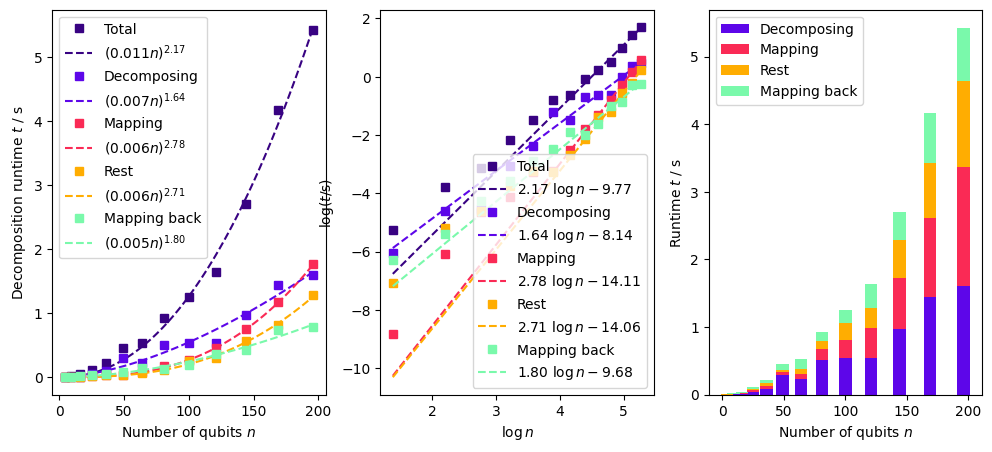

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
all_times = [times_total, times_decomposing, times_mapping, times_rest, times_mapping_back]
colors = ["xkcd:indigo", "xkcd:blue violet", "xkcd:red pink", "xkcd:orange yellow", "xkcd:seafoam green"]
labels = ["Total", "Decomposing", "Mapping", "Rest", "Mapping back"]
accum_times = 0
for times, label, c in zip(all_times, labels, colors):
    # f = lambda x, a, b: a * x + b
    f = lambda x, a, b: (b * x)**a
    # popt, pcov = curve_fit(f, np.log(ns)[3:], np.log(times)[3:])
    popt, pcov = curve_fit(f, ns[:len(times)], times)
    cont_ns = np.linspace(ns[0], ns[-1], 100)
    
    ax = axs[0]
    ax.plot(ns[:len(times)], times, marker="s", c=c, label=label, ls="")
    # ax.plot(cont_ns, np.exp(f(np.log(cont_ns), *popt)), ls = "--", c="xkcd:red pink", label=f"${popt[1]:.1f}n^{{{popt[0]:.2f}}}$")
    ax.plot(cont_ns, f(cont_ns, *popt), ls = "--", c=c, label=f"$({popt[1]:.3f}n)^{{{popt[0]:.2f}}}$")
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Decomposition runtime $t$ / s")
    ax.legend()
    
    ax = axs[1]
    ax.plot(np.log(ns[:len(times)]), np.log(times), marker="s", c=c, label=label, ls="")
    # ax.plot(np.log(ns), f(np.log(ns), *popt), ls = "--", c="xkcd:red pink", label=f"${popt[0]:.2f}\ \log n {popt[1]:.1f}$")
    ax.plot(np.log(cont_ns), np.log(f(cont_ns, *popt)), ls = "--", c=c, label=f"${popt[0]:.2f}\ \log n {popt[0] * np.log(popt[1]):.2f}$")
    ax.set_xlabel("$\log n$")
    ax.set_ylabel("$\log (t/\\text{s})$")
    ax.legend()
    
    ax = axs[2]
    if label!="Total":
        ax.bar(ns[:len(times)], times, bottom=accum_times, width=10, color=c, label=label)
        accum_times += np.array(times)
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Runtime $t$ / s")
    # ax.set_yscale("log")
    ax.legend()